In [1]:
import numpy as np
import matplotlib.pyplot as plt

##Define Constants

In [2]:
DENSITY = 1.0
VISCOSITY = 0.1
X_BOUNDARY = (0, 1)
Y_BOUNDARY = (0, 1)
X_STEP_SIZE = 0.025
Y_STEP_SIZE = 0.025
T_STEP_SIZE = 0.001
HORIZENTOL_VEL = 1.0
C =  ( X_STEP_SIZE**2 * Y_STEP_SIZE**2 * DENSITY ) / ( 2 * (X_STEP_SIZE**2 + Y_STEP_SIZE**2) )

In [3]:
x = np.arange(X_BOUNDARY[0], X_BOUNDARY[-1] + X_STEP_SIZE, X_STEP_SIZE)
y = np.arange(Y_BOUNDARY[0], Y_BOUNDARY[-1] + Y_STEP_SIZE , Y_STEP_SIZE)

In [4]:
X, Y = np.meshgrid(x, y, indexing="xy")

##Finite Difference Formulas

In [5]:
# Wrtie the difference schemes functions

#The central finite difference for second derivative with respect to x
def cent_diff_2nd_der_x(grid):
  output = np.copy(grid)
  output[1:-1, 1:-1] = (
      grid[1:-1, 2:]
      -
      2 * grid[1:-1, 1:-1]
      +
      grid[1:-1, :-2]
  ) / X_STEP_SIZE**2
  return output

#The central finite difference for second derivative with respect to y
def cent_diff_2nd_der_y(grid):
  output = np.copy(grid)
  output[1:-1, 1:-1] = (
      grid[2:, 1:-1]
      -
      2 * grid[1:-1, 1:-1]
      +
      grid[:-2, 1:-1]
  ) / Y_STEP_SIZE**2
  return output

#The centeral fintie difference for the first derivative with respect to x
def cent_diff_1st_der_x(grid):
  output = np.copy(grid)
  output[1:-1, 1:-1] = (
      grid[1:-1, 2:]
      -
      grid[1:-1, :-2]
  ) / ( 2 * X_STEP_SIZE )
  return output

#The centeral fintie difference for the first derivative with respect to y
def cent_diff_1st_der_y(grid):
  output = np.copy(grid)
  output[1:-1, 1:-1] = (
      grid[2:, 1:-1]
      -
      grid[:-2, 1:-1]
  ) / (2 * Y_STEP_SIZE)
  return output

#The backwaed difference for the derivative with repsect to x
def backward_diff_der_x(grid):
  output = np.copy(grid)
  output[1:-1, 1:] = (
      grid[1:-1, 1:]
      -
      grid[1:-1, :-1]
  ) / X_STEP_SIZE
  return output

#The backwaed difference for the derivative with repsect to x
def backward_diff_der_y(grid):
  output = np.copy(grid)
  output[:-1, 1:-1] = (
      grid[1:, 1:-1]
      -
      grid[:-1, 1:-1]
  ) / Y_STEP_SIZE
  return output

def pressure_diff_x(grid):
  output = np.copy(grid)
  output[1:-1, 1:-1] = (
      grid[1:-1, 2:]
      +
      grid[1:-1, :-2]
  ) / X_STEP_SIZE**2
  return output

def pressure_diff_y(grid):
  output = np.copy(grid)
  output[1:-1, 1:-1] = (
      grid[2:, 1:-1]
      +
      grid[:-2, 1:-1]
  )/ Y_STEP_SIZE**2
  return output

In [8]:
#apply boundary condition to x-component of the velocity
def u_boundary_condition(grid):
  grid[:, 0] = 0.0
  grid[:, -1] = 0.0
  grid[0, :] = 0.0
  grid[-1, :] = HORIZENTOL_VEL

#apply boundary condition to y-component of the velocity
def v_boundary_condition(grid):
  grid[:, 0] = 0.0
  grid[:, -1] = 0.0
  grid[0, :] = 0.0
  grid[-1, :] = 0.0

#Apply pressure boundary condition
def p_boundary_condition(grid):
  grid[:, -1] = grid[:, -2]
  grid[:, 0] = grid[:, 1]
  grid[0, :] = grid[1, :]
  grid[-1, :] = 0.0

##Initialize

In [9]:
#Initilaize the velocities and the pressure
u_prev = np.zeros_like(X)
v_prev = np.zeros_like(X)
p_prev = np.zeros_like(X)

#apply the boundary conditions
u_boundary_condition(u_prev)
v_boundary_condition(v_prev)
p_boundary_condition(p_prev)

##Solve

In [10]:
for _ in range(1000):
  #u_next
  u_next = u_prev + T_STEP_SIZE * (
      - u_prev * cent_diff_1st_der_x(u_prev)
      - v_prev * cent_diff_1st_der_y(u_prev)
      - (1/DENSITY) * cent_diff_1st_der_x(p_prev)
      + VISCOSITY * ( cent_diff_2nd_der_x(u_prev) + cent_diff_2nd_der_y(u_prev) )
  )
  u_boundary_condition(u_next)

  #v_next
  v_next = v_prev + T_STEP_SIZE * (
      - u_prev * cent_diff_1st_der_x(v_prev)
      - v_prev * cent_diff_1st_der_y(v_prev)
      - (1/DENSITY) * cent_diff_1st_der_y(p_prev)
      + VISCOSITY * ( cent_diff_2nd_der_x(v_prev) + cent_diff_2nd_der_y(v_prev) )
  )
  v_boundary_condition(v_next)

  #update
  u_prev = u_next
  v_prev = v_next

  #First smooth out the pressure by iterating few times
  for _ in range(50):
    p_next = C * (
        pressure_diff_x(p_prev) + pressure_diff_y(p_prev)
        - DENSITY * (
            (1/T_STEP_SIZE) * (cent_diff_1st_der_x(u_prev) + cent_diff_1st_der_y(v_prev) )
            - cent_diff_1st_der_x(u_prev)**2
            - 2 * cent_diff_1st_der_y(u_prev) * cent_diff_1st_der_x(v_prev)
            - cent_diff_1st_der_y(v_prev)**2
            - u_prev * cent_diff_2nd_der_x(u_prev)
            - v_prev * cent_diff_2nd_der_y(v_prev)
            - v_prev * cent_diff_1st_der_x(cent_diff_1st_der_y(u_prev))
            - u_prev * cent_diff_1st_der_y(cent_diff_1st_der_x(v_prev))
        )
    )
    p_boundary_condition(p_next)
    p_prev = p_next

##Plot

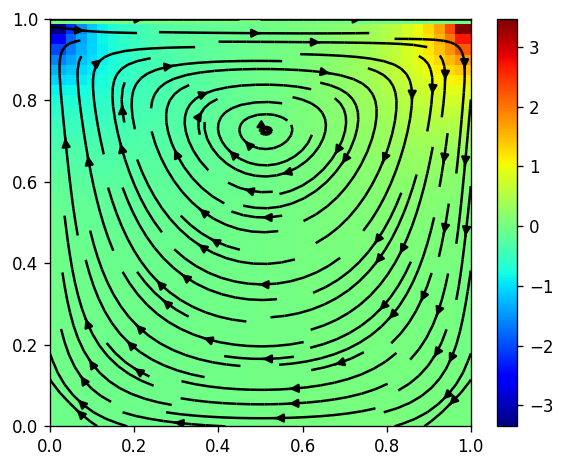

In [15]:
figure = plt.figure(figsize=(5, 4), tight_layout=True, dpi=120)
ax = figure.add_subplot(111)
ax.set_xlim(X_BOUNDARY)
ax.set_ylim(Y_BOUNDARY)
colormap = ax.pcolormesh(X, Y, p_next, cmap="jet", shading="auto")
figure.colorbar(colormap)
plt.streamplot(X, Y, u_next, v_next, color="black", density=1, maxlength=1)
plt.show()